In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Conv1D, TimeDistributed, LSTM
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./NSRDB_to_model.csv', index_col='datetime')
df.index.name= 'Date'
print(df.shape)
df.head()

(87696, 11)


,Wind_x,Wind_y,Dew Point,Cloud Type,Day Seasonality,Year Seasonality,Pressure,Relative Humidity,Temperature,Solar Zenith Angle,GHI
Date,,,,,,,,,,,
2016-01-01 00:00:00,-0.635439,-0.735724,-5.0,0,-1.407890e-12,-0.002666,990,49.00,5.0,168.95,0
2016-01-01 00:30:00,-0.635439,-0.735724,-5.0,0,1.305262e-01,-0.002308,990,49.00,5.0,166.74,0
2016-01-01 01:00:00,-0.558814,-0.795487,-5.0,0,2.588190e-01,-0.001950,990,48.97,5.0,162.23,0
2016-01-01 01:30:00,-0.558814,-0.795487,-5.0,0,3.826834e-01,-0.001591,990,48.97,5.0,156.74,0
2016-01-01 02:00:00,-0.479173,-0.851865,-5.0,0,5.000000e-01,-0.001233,990,48.98,5.0,150.83,0


In [3]:
new_cols = [col.lower().replace(' ', '_') for col in df.columns]
df.columns = new_cols

In [4]:
df.head()

,wind_x,wind_y,dew_point,cloud_type,day_seasonality,year_seasonality,pressure,relative_humidity,temperature,solar_zenith_angle,ghi
Date,,,,,,,,,,,
2016-01-01 00:00:00,-0.635439,-0.735724,-5.0,0,-1.407890e-12,-0.002666,990,49.00,5.0,168.95,0
2016-01-01 00:30:00,-0.635439,-0.735724,-5.0,0,1.305262e-01,-0.002308,990,49.00,5.0,166.74,0
2016-01-01 01:00:00,-0.558814,-0.795487,-5.0,0,2.588190e-01,-0.001950,990,48.97,5.0,162.23,0
2016-01-01 01:30:00,-0.558814,-0.795487,-5.0,0,3.826834e-01,-0.001591,990,48.97,5.0,156.74,0
2016-01-01 02:00:00,-0.479173,-0.851865,-5.0,0,5.000000e-01,-0.001233,990,48.98,5.0,150.83,0


In [ ]:
df.isnull().sum()

wind_x                0
wind_y                0
dew_point             0
cloud_type            0
day_seasonality       0
year_seasonality      0
pressure              0
relative_humidity     0
temperature           0
solar_zenith_angle    0
ghi                   0
dtype: int64

In [ ]:
df.columns

Index(['wind_x', 'wind_y', 'dew_point', 'cloud_type', 'day_seasonality',
       'year_seasonality', 'pressure', 'relative_humidity', 'temperature',
       'solar_zenith_angle', 'ghi'],
      dtype='object')

In [ ]:
features = ['temperature', 'wind_speed', 'pressure', 'solar_zenith_angle', 'relative_humidity', 'surface_albedo']

In [32]:
X = df.drop(columns=['ghi'])
y = df['ghi']

In [ ]:
def stack_sequences(X, y):
    X_list = []
    scaler = MinMaxScaler(feature_range=(0, 1))
    for col in X.columns:
        x1 = X[col].values
        x1 = x1.reshape(len(x1), 1)
        x1_ss = scaler.fit_transform(x1)
        X_list.append(x1_ss)
    y1 = y.values
    y1 = y1.reshape(len(y1), 1)
    y1_ss = scaler.fit_transform(y1)
    X_list.append(y1_ss)
    
    return np.hstack(X_list)

In [ ]:
dataset_stacked = stack_sequences(X, y)

In [35]:
dataset_stacked[0].shape

(11,)

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
    
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

def split_sequences(sequences, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(sequences)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1
  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break
  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 120, 48
# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

X.shape (87530, 120, 10)
y.shape (87530, 48)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

In [ ]:
X_train.shape

(70024, 120, 10)

In [ ]:
y_train.shape

(70024, 48)

## WaveNet Model

In [3]:
def univarite_sequence(n_steps_in, n_out, data):
    X = list()
    y = list()
    for i in range(len(data)):
        X.append(data[i:i+n_steps_in].values)
        y.append(data[i+n_steps_in:i+(n_steps_in + n_out)].values)
        if (i+n_steps_in+n_out) >= len(data):
            break
    return np.array(X), np.array(y)

steps_in = 96
steps_out = 96
X_new, y_new = univarite_sequence(steps_in, steps_out, df)


In [4]:
train_X, test_X, train_y, test_y = train_test_split(X_new, y_new, shuffle=False)

In [ ]:
ms = MinMaxScaler()
train_X_s = ms.fit_transform(train_X)
test_X_s = ms.transform(test_X)

m2 = MinMaxScaler()
train_y_s = ms.fit_transform(train_y)
test_y_s = ms.transform(test_y)


In [5]:
print(train_X.shape)
print(train_y.shape)

(65412, 240, 11)
(65412, 240, 11)


In [ ]:
train_X_s.shape

(12564, 720)

In [ ]:
train_X_s = np.array(train_X_s).reshape(len(train_X_s), steps_in, 1)
test_X_s = np.array(test_X_s).reshape(len(test_X_s), steps_in, 1)
train_y_s = np.array(train_y_s)
test_y_s = np.array(test_y_s)

In [7]:
train_X = np.array(train_X)# .reshape(len(train_X), steps_in,11,1)
test_X = np.array(test_X)# .reshape(len(test_X), steps_in,11, 1)
train_y = np.array(train_y)
test_y = np.array(test_y)

In [5]:
# source: https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'activation': self.activation,
        })
        return config 
    
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = keras.activations.linear(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate
        

def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z
    

def wavenet_model_setup(n_layers_per_block, n_blocks, n_filters, n_outputs, feature_dim, name, last_activation='relu'):
    # n_layers_per_block = 10 in the paper
    # n_blocks = 3 in the paper
    # n_filters = 128 in the paper
    # n_outputs = 256 in the paper
    # last_activation determines the output codomain
    train_size = 96
    
    inputs = keras.layers.Input(shape=[train_size, feature_dim])
    z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
    skip_to_last = []
    for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
        z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
        skip_to_last.append(skip)
    z = keras.activations.relu(keras.layers.Add()(skip_to_last))
    z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
    out = keras.layers.Conv1D(feature_dim, kernel_size=1, activation=last_activation)(z)
    #out = layers.Flatten()(out)
    #out = Dense(n_outputs)(out)
    return keras.models.Model(inputs=[inputs], outputs=[out], name = name)

In [6]:
model_wave = wavenet_model_setup(7, 3, 128, 48, feature_dim=11, name='Wave', last_activation='linear')

In [7]:
model_wave.compile(loss="mse", optimizer="adam", metrics=['mae'])
history_wave = model_wave.fit(train_X, train_y, epochs=5,
                    validation_data=(test_X, test_y))

Epoch 1/5
2051/2051 [==============================] - 194s 79ms/step - loss: 2266.2866 - mae: 11.4311 - val_loss: 728.5274 - val_mae: 6.9806
Epoch 2/5
2051/2051 [==============================] - 147s 72ms/step - loss: 947.6600 - mae: 7.9674 - val_loss: 728.4163 - val_mae: 7.1017
Epoch 3/5
2051/2051 [==============================] - 148s 72ms/step - loss: 923.6883 - mae: 7.7527 - val_loss: 806.8503 - val_mae: 8.3307
Epoch 4/5
2051/2051 [==============================] - 153s 75ms/step - loss: 903.9752 - mae: 7.5695 - val_loss: 786.9404 - val_mae: 7.7965
Epoch 5/5
2051/2051 [==============================] - 156s 76ms/step - loss: 875.2422 - mae: 7.3732 - val_loss: 734.3542 - val_mae: 6.6130


In [8]:
test_y.shape

(21877, 96, 11)

In [ ]:
model_wave.summary

In [10]:
preds_wave = model_wave.predict(test_X)

684/684 [==============================] - 18s 25ms/step


In [11]:
preds_wave.shape

(21877, 96, 11)

In [3]:
r2_score(test_y[:, -1, -1], preds_wave[:, -1, -1])

NameError: ignored

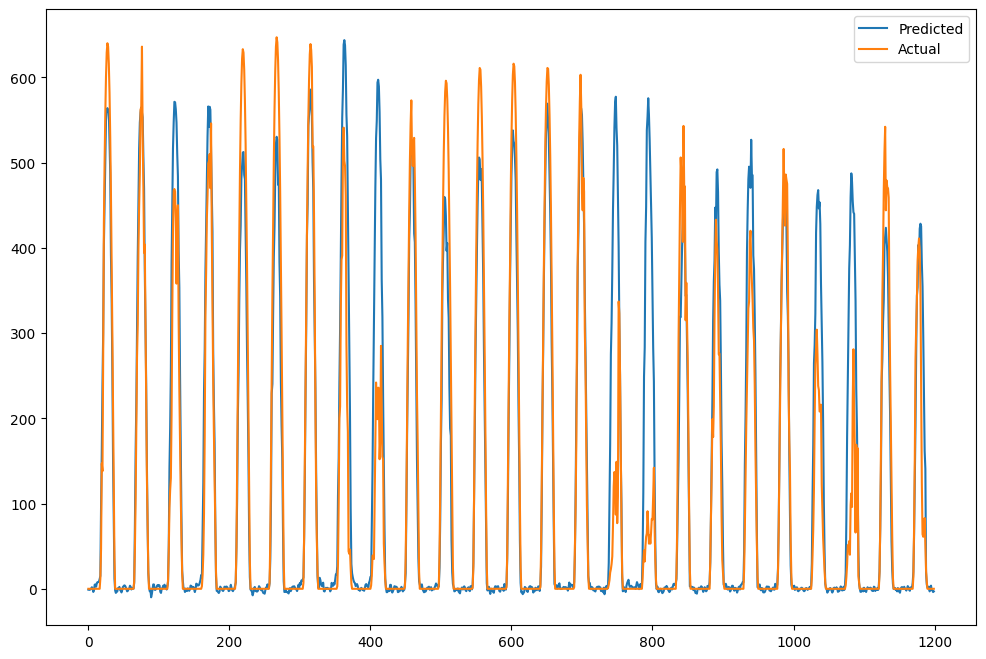

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(preds_wave[:, 0, -1][2000:3200], label='Predicted')
plt.plot(test_y[:, 0, -1][2000:3200], label='Actual')
plt.legend();

In [ ]:
model_wave.summary()

In [ ]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'activation': self.activation,
        })
        return config 
    
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = keras.activation.linear(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate
        

def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv2D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z
    

def wavenet_model_setup(n_layers_per_block, n_blocks, n_filters, n_outputs, feature_dim, name, last_activation='relu'):
    # n_layers_per_block = 10 in the paper
    # n_blocks = 3 in the paper
    # n_filters = 128 in the paper
    # n_outputs = 256 in the paper
    # last_activation determines the output codomain
    train_size = 120
    
    inputs = keras.layers.Input(shape=[train_size, feature_dim])
    z = keras.layers.Conv2D(n_filters, kernel_size=2, padding="causal")(inputs)
    skip_to_last = []
    for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
        z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
        skip_to_last.append(skip)
    z = keras.activations.relu(keras.layers.Add()(skip_to_last))
    z = keras.layers.Conv2D(n_filters, kernel_size=1, activation="relu")(z)
    out = keras.layers.Conv2D(n_filters, kernel_size=1, activation=last_activation)(z)
    out = layers.Flatten()(out)
    out = Dense(n_outputs)(out)
    return keras.models.Model(inputs=[inputs], outputs=[out], name = name)